<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Функции" data-toc-modified-id="Функции-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Функции</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Задачи:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, mean_squared_error
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Проведем ресемплирование по одному часу

In [3]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

Оптимизируем типы данных

In [4]:
df['num_orders'] = pd.to_numeric(df['num_orders'],
                                 downcast='integer')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int16
dtypes: int16(1)
memory usage: 43.1 KB


In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
df.isna().mean()

num_orders    0.0
dtype: float64

* Пропусков не обнаружено

## Анализ

Посмотрим статестические данные нашего датасета

In [8]:
df['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

Построим график с нашими данными

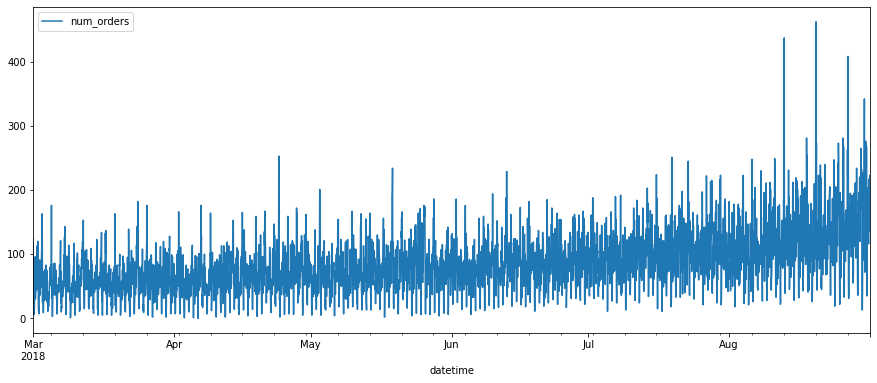

In [9]:
df.plot(figsize = (15, 6))
plt.show()

* Слишком много колебаний во временном ряду, чтобы их снизить, применим скользящее среднее

Функция для построения графика скользящего среднего

In [10]:
def plotMovingAverage(df, n):

    rolling_mean = df.rolling(n).mean()

    # Доверительные интервалы для сглаженных значений
    #rolling_std =  df.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title(f'Скользящая средняя, размер окна = {n}')
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #lt.plot(lower_bond, "r--")
    #plt.plot(df, label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Построим график скользящего среднего, с размером окна равным одной недели

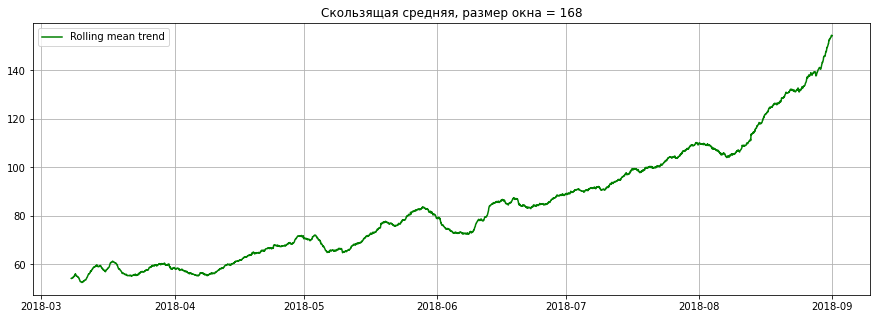

In [11]:
plotMovingAverage(df, 24*7)

* По графику прослеживается планомерный рост кол-ва заказов такси, с резким ростом в августе

Функция для построения графиков: тренд, сезонная составляющая и остаток декомпозиции

In [12]:
def decomposed(df, chart='123'):
    decomposed_data = seasonal_decompose(df)
    # Тренд
    if '1' in chart:
        decomposed_data.trend.plot(figsize=(15,5))
        plt.title('Тренд')
        plt.show()
    # Сезонная составляющая
    if '2' in chart:
        decomposed_data.seasonal.plot(figsize=(15,6))
        plt.title('Сезонная составляющая')
        plt.show()
    # Остаток декомпозиции
    if '3' in chart:
        decomposed_data.resid.plot(figsize=(15,6))
        plt.title('Остаток декомпозиции')
        plt.show()

Построим графики: тренд, сезонная составляющая и остаток декомпозиции

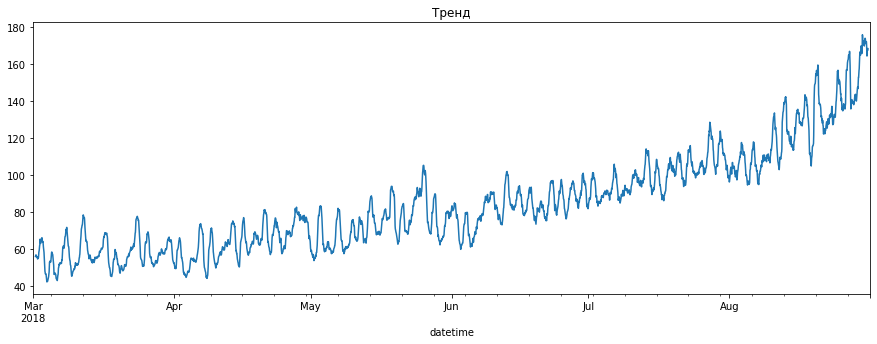

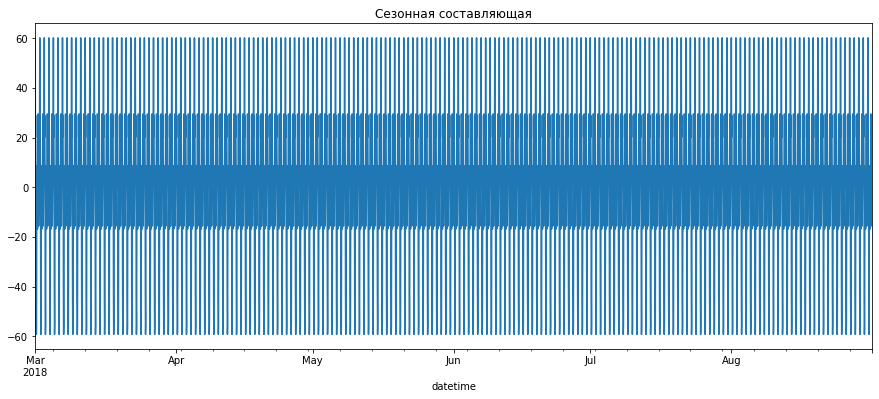

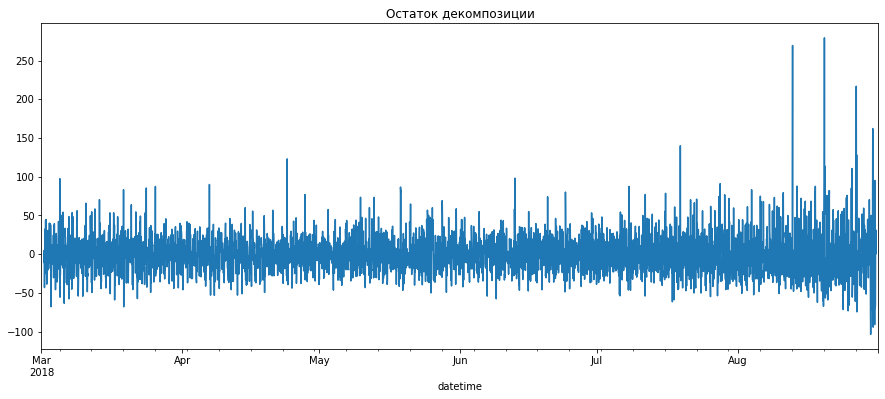

In [13]:
decomposed(df)

* Наблюдаем тренд планомерного роста кол-ва заказов;
* Сезонную составляющую опредилить по данному датасету не удаётся.

Постороим график сезонной составляющей для первых двух дней датасета

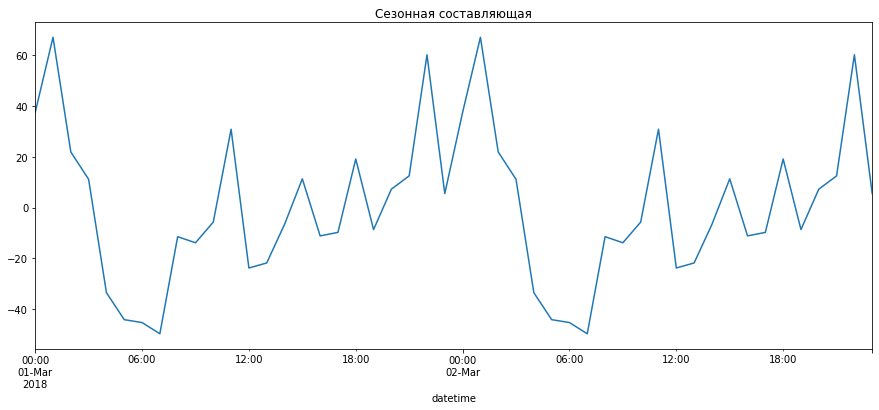

In [14]:
decomposed(df['2018-03-01':'2018-03-02'], '2')

* Рано утром меньше всего заказов такси, а в полночь пиковое значение заказов.

*** Выводы***

* Статистические данные:
    * Среднее значение - 84;
    * Медиана - 78;
    * Стандартное отклонение - 45;
    * Минимальное значение - 0;
    * Максимальное значение - 462.
* Прослеживается планомерный рост кол-ва заказов такси, с резким ростом в августе;
* Рано утром меньше всего заказов такси, а в полночь пиковое значение заказов.

## Обучение

### Функции

Функция для подсчёта метрики RMSE

In [15]:
def rmse(prediction, y):
    return mean_squared_error(prediction, y, squared=False)

Функция для добавления новых признаков

In [16]:
def make_features(df, max_lag):
    data = df.copy()
    # Довление признаков с датой: месяц, день, день недели, выходные и час
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['weekday'] = data.index.dayofweek
    data['is_weekend'] = data.weekday.isin([5,6])*1
    data['hour'] = data.index.hour
    
    # добавляем лаги исходного ряда в качестве признаков
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data = data.dropna()
    
    X= data.drop('num_orders', axis=1)
    y = data['num_orders']
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train, X_test, y_train, y_test\
        = train_test_split(X, y, test_size=0.1,
                           shuffle=False, random_state=12345)
    return X_train, X_test, y_train, y_test

Функция для кросс-валидация на временных рядах

In [17]:
def timeseriesCVscore(model, X, y, splits):
    # вектор ошибок
    errors = []

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(splits)
    
    step = 0

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(X):
        
        X_train = X.values[train]
        X_test = X.values[test]
                
        y_train = y.values[train]
        y_test = y.values[test]
       
        
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)

        error = rmse(prediction, y_test)
        errors.append(error)
        
        print(f'{step} фолд, RMSE: {round(error, 2)}')
        step += 1
        
    full_data_error = round(error, 2)
    avg_rmse = round(np.mean(np.array(errors)), 2)
    

    print()
    print(f'Средние значение метрики RMSE: {avg_rmse}')
    print('------------------------------------------')
    
    return avg_rmse, full_data_error

Создадим сводную таблицу, для добавления оценок работы моделей

In [18]:
table_estimation = pd.DataFrame(columns=['Name model', 'Max_lag',
                                         'AVG RMSE', 'Full data RMSE'])

Функция для выводов оценок работы модели и записи из в сводную таблицу

In [19]:
def result_model(name):
    global table_estimation, best_max_lag, best_avg_error, best_full_data_error
    
    print('Лучшие результаты модели:')
    #print()
    print('Max_lag: ', best_max_lag)
    print('AVG RMSE: ', best_avg_error)
    print('Full data RMSE: ', best_full_data_error)
    
    table_estimation = table_estimation.append({'Name model':name,
                         'Max_lag':best_max_lag, 'AVG RMSE':best_avg_error,
                         'Full data RMSE':best_full_data_error}, ignore_index=True)

### LinearRegression

In [20]:
lr = LinearRegression()

Поиск лучшего значения кол-ва лагов

In [21]:
best_avg_error = 100
for max_lag in range(150, 251, 10):
    print(f'max_lag: {max_lag}')
    print('')
    X_train, X_test, y_train, y_test = make_features(df, max_lag)
    avg_error, full_data_error = timeseriesCVscore(lr, X_train, y_train, 5)
    if avg_error < best_avg_error:
        best_avg_error = avg_error
        best_full_data_error = full_data_error
        best_max_lag = max_lag

max_lag: 150

0 фолд, RMSE: 21.47
1 фолд, RMSE: 21.77
2 фолд, RMSE: 21.87
3 фолд, RMSE: 24.21
4 фолд, RMSE: 29.9

Средние значение метрики RMSE: 23.84
------------------------------------------
max_lag: 160

0 фолд, RMSE: 21.84
1 фолд, RMSE: 21.85
2 фолд, RMSE: 22.15
3 фолд, RMSE: 24.19
4 фолд, RMSE: 29.77

Средние значение метрики RMSE: 23.96
------------------------------------------
max_lag: 170

0 фолд, RMSE: 20.35
1 фолд, RMSE: 20.89
2 фолд, RMSE: 21.52
3 фолд, RMSE: 22.29
4 фолд, RMSE: 28.16

Средние значение метрики RMSE: 22.64
------------------------------------------
max_lag: 180

0 фолд, RMSE: 20.87
1 фолд, RMSE: 20.93
2 фолд, RMSE: 21.57
3 фолд, RMSE: 22.33
4 фолд, RMSE: 28.15

Средние значение метрики RMSE: 22.77
------------------------------------------
max_lag: 190

0 фолд, RMSE: 21.34
1 фолд, RMSE: 20.96
2 фолд, RMSE: 21.55
3 фолд, RMSE: 22.39
4 фолд, RMSE: 28.16

Средние значение метрики RMSE: 22.88
------------------------------------------
max_lag: 200

0 фолд, RMSE

Выведем результаты работы модели

In [22]:
result_model('LinearRegression')

Лучшие результаты модели:
Max_lag:  170
AVG RMSE:  22.64
Full data RMSE:  28.16


### DecisionTreeRegressor

In [23]:
tree= DecisionTreeRegressor(random_state=12345)

Поиск лучшего значения кол-ва лагов и максимального размера дерева

In [24]:
best_avg_error = 100
for max_lag in range(100, 201, 5):
    print(f'max_lag: {max_lag}')
    print('')
    X_train, X_test, y_train, y_test = make_features(df, max_lag)
    for depth in range(2, 11, 1):
        print(f'max_depth: {depth}')
        print('')
        tree= DecisionTreeRegressor(max_depth=depth, random_state=12345)        
        avg_error, full_data_error = timeseriesCVscore(tree, X_train, y_train, 5)
        if avg_error < best_avg_error:
            best_avg_error = avg_error
            best_full_data_error = full_data_error
            best_max_lag = max_lag
            best_max_depth = depth

max_lag: 100

max_depth: 2

0 фолд, RMSE: 26.69
1 фолд, RMSE: 27.79
2 фолд, RMSE: 28.74
3 фолд, RMSE: 30.93
4 фолд, RMSE: 41.08

Средние значение метрики RMSE: 31.04
------------------------------------------
max_depth: 3

0 фолд, RMSE: 26.47
1 фолд, RMSE: 25.69
2 фолд, RMSE: 27.81
3 фолд, RMSE: 29.26
4 фолд, RMSE: 40.06

Средние значение метрики RMSE: 29.86
------------------------------------------
max_depth: 4

0 фолд, RMSE: 26.99
1 фолд, RMSE: 25.59
2 фолд, RMSE: 27.16
3 фолд, RMSE: 27.44
4 фолд, RMSE: 37.45

Средние значение метрики RMSE: 28.93
------------------------------------------
max_depth: 5

0 фолд, RMSE: 26.77
1 фолд, RMSE: 26.25
2 фолд, RMSE: 27.42
3 фолд, RMSE: 27.33
4 фолд, RMSE: 35.65

Средние значение метрики RMSE: 28.68
------------------------------------------
max_depth: 6

0 фолд, RMSE: 28.32
1 фолд, RMSE: 27.84
2 фолд, RMSE: 29.5
3 фолд, RMSE: 27.84
4 фолд, RMSE: 34.53

Средние значение метрики RMSE: 29.61
------------------------------------------
max_depth: 7

Выведем результаты работы модели

In [25]:
result_model('DecisionTreeRegressor')

Лучшие результаты модели:
Max_lag:  185
AVG RMSE:  26.88
Full data RMSE:  34.96


### CatBoostRegressor

In [26]:
cat = CatBoostRegressor(iterations=300, learning_rate = 0.1,
                        random_state=12345, metric_period=50,
                        eval_metric='RMSE')

Поиск лучшего значения кол-ва лагов

In [27]:
best_avg_error = 100
for max_lag in range(150, 201, 10):
    print(f'max_lag: {max_lag}')
    print('')
    X_train, X_test, y_train, y_test = make_features(df, max_lag)    
    avg_error, full_data_error = timeseriesCVscore(cat, X_train, y_train, 5)
    if avg_error < best_avg_error:
        best_avg_error = avg_error
        best_full_data_error = full_data_error
        best_max_lag = max_lag

max_lag: 150

0:	learn: 28.2733112	total: 73.3ms	remaining: 21.9s
50:	learn: 13.0166881	total: 1s	remaining: 4.91s
100:	learn: 8.9216149	total: 1.88s	remaining: 3.7s
150:	learn: 6.2292232	total: 2.73s	remaining: 2.7s
200:	learn: 4.4724139	total: 3.6s	remaining: 1.77s
250:	learn: 3.2454877	total: 4.47s	remaining: 873ms
299:	learn: 2.4087861	total: 5.31s	remaining: 0us
0 фолд, RMSE: 20.99
0:	learn: 29.5512686	total: 30.5ms	remaining: 9.11s
50:	learn: 14.8838996	total: 1.07s	remaining: 5.24s
100:	learn: 11.7568816	total: 2.09s	remaining: 4.11s
150:	learn: 9.5280299	total: 3.1s	remaining: 3.06s
200:	learn: 7.6080777	total: 4.15s	remaining: 2.04s
250:	learn: 6.2381287	total: 5.24s	remaining: 1.02s
299:	learn: 5.1900231	total: 6.29s	remaining: 0us
1 фолд, RMSE: 21.82
0:	learn: 31.4982715	total: 35.9ms	remaining: 10.7s
50:	learn: 16.2177436	total: 1.24s	remaining: 6.06s
100:	learn: 13.8218706	total: 2.46s	remaining: 4.85s
150:	learn: 11.5987462	total: 3.63s	remaining: 3.58s
200:	learn: 9.8719

Выведем результаты работы модели

In [28]:
result_model('CatBoostRegressor')

Лучшие результаты модели:
Max_lag:  180
AVG RMSE:  22.55
Full data RMSE:  29.38


### Вывод

In [29]:
table_estimation

,Name model,Max_lag,AVG RMSE,Full data RMSE
0,LinearRegression,170,22.64,28.16
1,DecisionTreeRegressor,185,26.88,34.96
2,CatBoostRegressor,180,22.55,29.38


* Линейная регрессия и CatBoost регрессия показали близкие результаты средней ошибки RMSE на кросс-валидации (22.64 и 22.55), но линейная регрессия показала лучшие результаты на полных данных - 28.16 против 29.38 у CatBoost регрессии;
* Проверим нашу лучшую модель на тестовых дынных.

## Тестирование

In [30]:
X_train, X_test, y_train, y_test = make_features(df, 170)

In [31]:
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
print('Результаты лучшей модели на тестовых данных:', round(rmse(prediction, y_test), 2))

Результаты лучшей модели на тестовых данных: 35.2


* Тестирование модели прошло успешно, значение RMSE = 35.2, что меньше установленного лимита в 48

In [32]:
prediction = pd.Series(prediction, index=y_test.index)

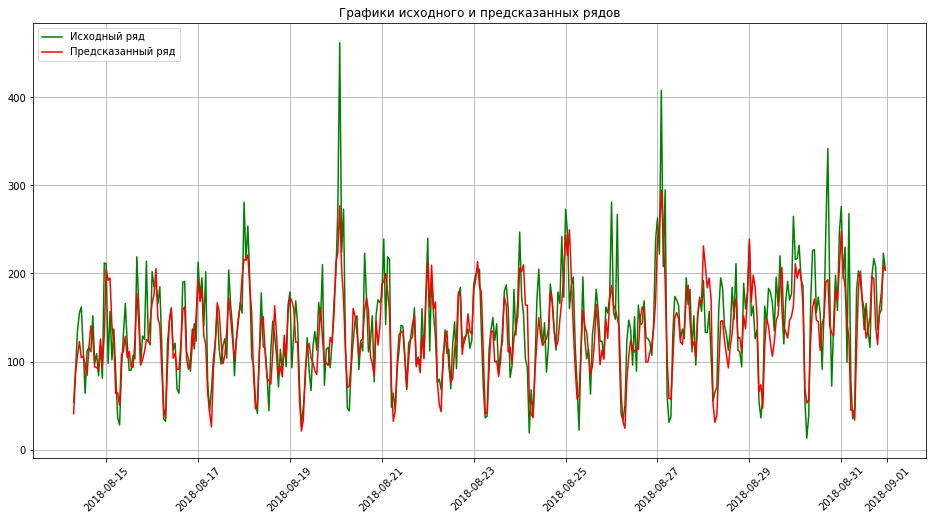

In [33]:
plt.figure(figsize=(16,8))
plt.title(f'Графики исходного и предсказанных рядов')
plt.plot(y_test, "g", label="Исходный ряд")
plt.plot(prediction , "r", label="Предсказанный ряд")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## Общие выводы

* Статистические данные:
    * Среднее значение - 84;
    * Медиана - 78;
    * Стандартное отклонение - 45;
    * Минимальное значение - 0;
    * Максимальное значение - 462.
* Прослеживается планомерный рост кол-ва заказов такси, с резким ростом в августе;
* Рано утром меньше всего заказов такси, а в полночь пиковое значение заказов;

Показатели моделей:

In [34]:
table_estimation

,Name model,Max_lag,AVG RMSE,Full data RMSE
0,LinearRegression,170,22.64,28.16
1,DecisionTreeRegressor,185,26.88,34.96
2,CatBoostRegressor,180,22.55,29.38


* Линейная регрессия и CatBoost регрессия показали близкие результаты средней ошибки RMSE на кросс-валидации (22.64 и 22.55), но линейная регрессия показала лучшие результаты на полных данных - 28.16 против 29.38 у CatBoost регрессии;
* Проверка модели линейной регрессии на тестовых данных прошла успешно, значение RMSE = 35.2, что меньше установленного лимита в 48